In [1]:
# # 사용 가능한 GPU 확인
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # GPU 사용 설정
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/drive/MyDrive/open.zip"

In [3]:
import os
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/functions')
# sys.path.append(os.path.join(os.getcwd(), os.path.pardir, 'functions'))
from predict_and_test import get_test_csv_fn

from tensorflow.config.experimental import enable_op_determinism as tf_enable_op_determinism
from tensorflow.keras.layers import GlobalAveragePooling2D as keras_GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator as keras_ImageDataGenerator
from tensorflow.keras.utils import set_random_seed as keras_set_random_seed
from tensorflow.keras.applications import Xception as keras_Xception
from tensorflow.keras.optimizers import Adam as keras_Adam
from tensorflow.keras.layers import Dense as keras_Dense
from tensorflow.keras.layers import Input as keras_Input
from tensorflow.keras.models import Model as keras_Model
from tensorflow import random as tf_random
import matplotlib.pyplot as mat_plt
from datetime import datetime
import pandas as pd
import numpy as np
import random

In [4]:
# ========= 코드 그대로 모델 생성하고 학습시켜보기 =========
# https://techblog-history-younghunjo1.tistory.com/261

# Xception + keras의 ImageDataGenerator 객체 및 flow_from_directory() 함수 사용

# v3.1.1 데이콘 리더 보드 점수 => 모두 오염으로 판단하여 제출하지 않음
# v3.1.2 데이콘 리더 보드 점수 => 0.4140977628

# 최종 수정 2023.05.16 (실행일 동일)
# 해당 코드는 코랩 GPU T4 고용량 RAM에서 실행시킨 결과이며 v3.1.2 버전에서 리팩토링만 진행하였음

# TRAIN_FOLDER_PATH = '../../open/train/'
# OPEN_FOLDER_PATH = '../../open/'
TRAIN_FOLDER_PATH = '/content/train/'
OPEN_FOLDER_PATH = '/content/'

EPOCHS = 10
RESIZED_WIDTH = 100
RESIZED_HEIGHT = 100

# 확인 필요
SEED = 20230426
random.seed(SEED)
np.random.seed(SEED)
tf_random.set_seed(SEED)
keras_set_random_seed(SEED)
tf_enable_op_determinism()

train_img_generator = keras_ImageDataGenerator(rescale=1/255.)

# defalut : shuffle=True, batch_size=32, color_mode='rgb', class_mode='categorical'
train_img_flow = train_img_generator.flow_from_directory(
    TRAIN_FOLDER_PATH, target_size=(RESIZED_WIDTH, RESIZED_HEIGHT))

# 3457개의 이미지 데이터 / batch_size 32 = 109
print(len(train_img_flow))

# for img in train_img_flow:
#     print('img :', img)

def create_model_fn():

    input_tensor = keras_Input(shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3))

    pretrained_model = keras_Xception(
        input_tensor=input_tensor, include_top=False, weights='imagenet')
    pretrained_output = pretrained_model.output

    x = keras_GlobalAveragePooling2D()(pretrained_output)
    x = keras_Dense(units=128, activation='relu')(x)
    output = keras_Dense(units=19, activation='softmax')(x)

    model = keras_Model(inputs=input_tensor, outputs=output)
    model.summary()
    return model

model = create_model_fn()
print('weights :', model.get_weights())
model.compile(optimizer=keras_Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['acc'])

# fit() 함수의 default : batch_size = 32
history = model.fit(train_img_flow, epochs=EPOCHS)

# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
model.save(f'model_{now}.h5')

# ========================================================

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
       -0.11911067, -0.39081907,  0.25265282, -0.5120399 , -0.8072624 ,
       -0.07597888,  0.00482507, -0.72381574, -0.06190765, -0.07366166,
       -0.2775225 , -0.05441244,  0.44460356, -0.3624139 , -0.7875807 ,
       -0.6701451 , -0.28975418, -0.6087971 , -0.5602521 , -0.41197973,
       -0.37634572, -0.24643703, -0.5822336 , -0.6658754 , -0.10641955,
       -0.56205535, -0.85476476, -0.32394096,  0.18668607, -0.4102495 ,
       -0.16028695, -0.21507463, -0.40497124, -0.51984406, -0.49901387,
       -0.48580953, -0.22067931, -0.38138545, -0.30599585, -1.0353988 ,
       -0.6360721 , -0.5178928 , -0.4815655 , -0.25318864,  0.03744952,
       -0.7182947 , -1.0565602 , -0.34983978, -0.3353995 ,  0.09845871,
       -0.27481076, -0.36363593, -0.315017  ,  0.00223702, -0.6229212 ,
       -0.6435845 ,  0.05805622, -0.23918502, -0.87746793, -0.4214964 ,
       -0.66801935, -0.41262048, -0.60975   , -0.0599682 , -0.3471681 ,
       -0.13200317, -0.28111

loss : [1.9924322366714478, 0.9616585373878479, 0.5505849123001099, 0.29683980345726013, 0.19868029654026031, 0.10838182270526886, 0.09605631232261658, 0.05217762291431427, 0.07040681689977646, 0.05528441444039345]


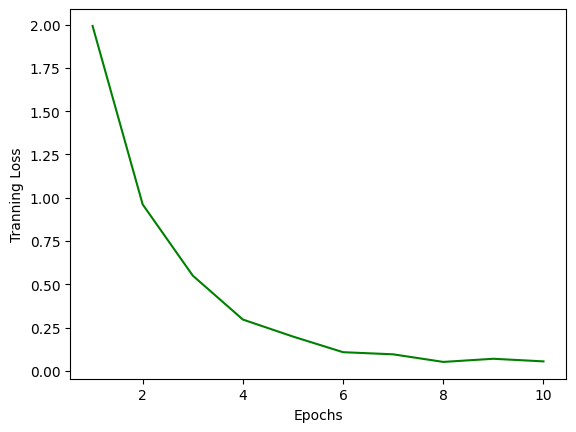

In [5]:
# ======= 학습 횟수에 따른 오차 변화 그래프 =======

loss = history.history['loss']
print('loss :', loss)

mat_plt.plot(range(1, EPOCHS + 1), loss, 'g')
mat_plt.title = 'Tranning Loss'
mat_plt.ylabel('Tranning Loss')
mat_plt.xlabel('Epochs')
mat_plt.show()

# ===============================================

In [6]:
# 모두 한 가지로만 예측함 (v3.1.1)
# from predict_and_test import get_predict_result_fn
# predicted_result = get_predict_result_fn(RESIZED_WIDTH, RESIZED_HEIGHT, model)
# get_test_csv_fn(predicted_result)

In [7]:
# ImageDataGenerator 객체를 사용한 테스트 진행 (v3.1.2 ~ 추후 보완한 코드)
test_img_generator = keras_ImageDataGenerator(rescale=1/255.)
test_img_flow = test_img_generator.flow_from_directory(
    OPEN_FOLDER_PATH, classes=['test'], class_mode=None, shuffle=False, target_size=(RESIZED_WIDTH, RESIZED_HEIGHT))

predicted_result = model.predict(test_img_flow)
csv_file_name = get_test_csv_fn(predicted_result, 'v3_Xception')

Found 792 images belonging to 1 classes.
25/25 [==============================] - 11s 403ms/step
predicted_labels : ['훼손', '훼손', '훼손', '몰딩수정', '오염', '면불량', '훼손', '훼손', '오염', '오타공', '몰딩수정', '오타공', '오염', '오염', '훼손', '오염', '훼손', '걸레받이수정', '오염', '오염', '오염', '훼손', '훼손', '면불량', '꼬임', '오염', '면불량', '면불량', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '터짐', '훼손', '훼손', '오염', '오타공', '훼손', '훼손', '오염', '터짐', '오염', '훼손', '면불량', '오염', '걸레받이수정', '오염', '훼손', '오염', '오염', '훼손', '석고수정', '훼손', '오염', '훼손', '석고수정', '훼손', '오염', '오타공', '몰딩수정', '터짐', '오염', '면불량', '훼손', '오염', '오염', '훼손', '석고수정', '오염', '오염', '훼손', '오염', '오타공', '오염', '훼손', '훼손', '걸레받이수정', '오염', '훼손', '석고수정', '오염', '오타공', '걸레받이수정', '오염', '면불량', '면불량', '오염', '오염', '오염', '훼손', '훼손', '오염', '훼손', '훼손', '훼손', '오타공', '훼손', '훼손', '걸레받이수정', '훼손', '오염', '터짐', '훼손', '오염', '가구수정', '훼손', '훼손', '훼손', '터짐', '오염', '훼손', '훼손', '오염', '오염', '훼손', '오염', '면불량', '곰팡이', '훼손', '오염', '오염', '면불량', '훼손', '훼손', '훼손', '훼손', '훼손', '걸레받이수정', '훼손', '훼손', '걸레받이수정', '오염', '훼손', '훼손', '면불량'

In [8]:
predicted_defect_types = pd.read_csv(csv_file_name)
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
훼손         319
오염         247
면불량         39
오타공         35
터짐          32
꼬임          31
곰팡이         22
몰딩수정        14
석고수정        14
걸레받이수정      11
들뜸           9
피스           8
이음부불량        4
가구수정         3
녹오염          2
울음           1
창틀,문틀수정      1
Name: label, dtype: int64


In [1]:
# v3.1.2 csv 파일과 비교
predicted_defect_types = pd.read_csv('v3_1_2_Xception_test_20230520_065234.csv')
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
label
훼손         392
오염         200
터짐          54
꼬임          24
걸레받이수정      23
오타공         21
몰딩수정        18
면불량         16
곰팡이         15
녹오염          8
피스           6
이음부불량        4
석고수정         4
가구수정         2
창틀,문틀수정      2
들뜸           2
울음           1
Name: count, dtype: int64
